In [1]:
# Import required libraries
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

Using TensorFlow backend.


True

In [2]:
# Create and load the fine-tuned image classifier (MobileNet, in this case)

mobile = tf.keras.applications.mobilenet.MobileNet()
x = mobile.layers[-6].output
output = Dense(units=2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)
for layer in model.layers:
    layer.trainable = False
    
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Path to the weights file of our fine-tuned model
model.load_weights('fine_tuned_flood_detection_model')
# Define Labels
labels = ['Flooding', 'No Flooding']

In [3]:
# Preprocess input image so that it can be fed to our CNN
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image
# Get labels from probability vector
def get_imagenet_label(probs):
    result = np.argmax(probs)
    max_value = np.max(probs)
    return labels[result], max_value

In [4]:
# Specify image path and predict the relevant label using fine-tuned model
image_path = '/Users/SohailKhan/Desktop/DeepLearning/MyProject/AdversarialML/evaluate/11.jpg'
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_raw)
image = preprocess(image)
image_probs = model.predict(image, steps=1)

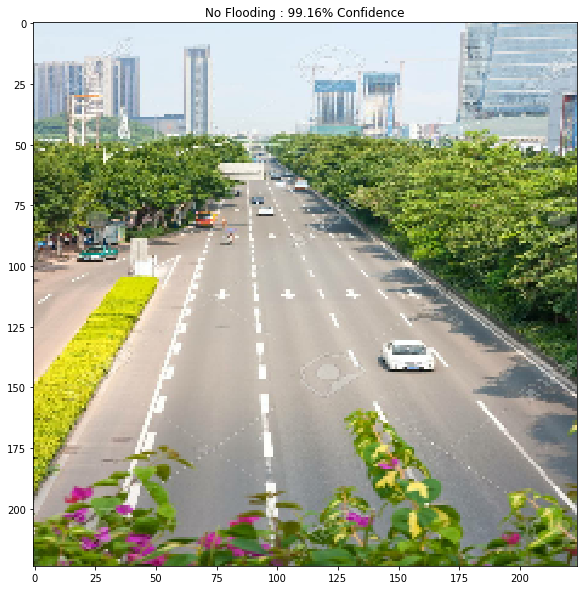

In [5]:
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.grid'] = False


plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [6]:
# Create adversarial Pattern (FGSM)

loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

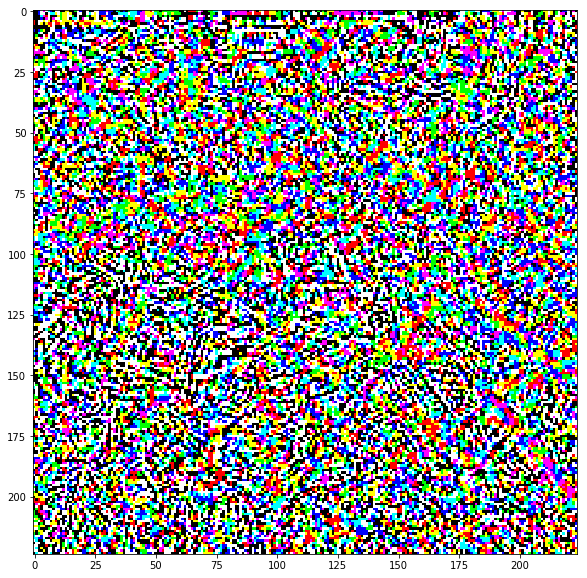

In [10]:
# Specify the input label of the provided image
no_flooding_index = 1
label = tf.one_hot(no_flooding_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [8]:
def display_images(image, description):
    label, confidence = get_imagenet_label(model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

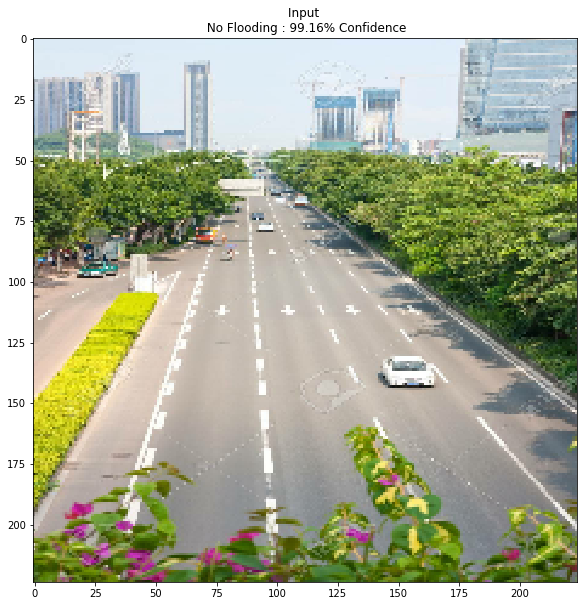

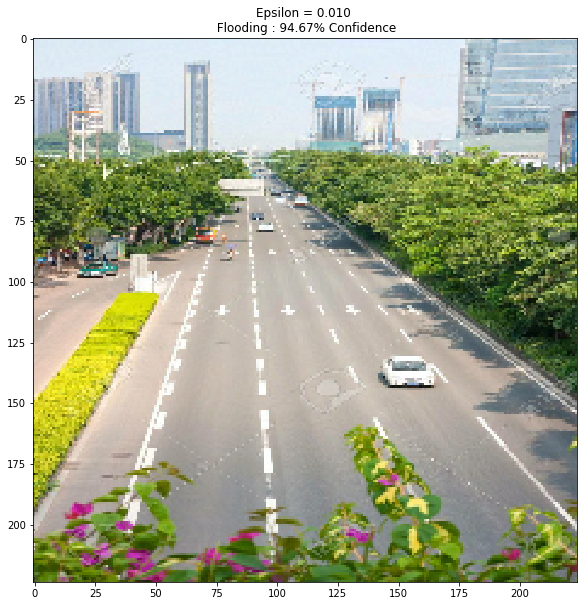

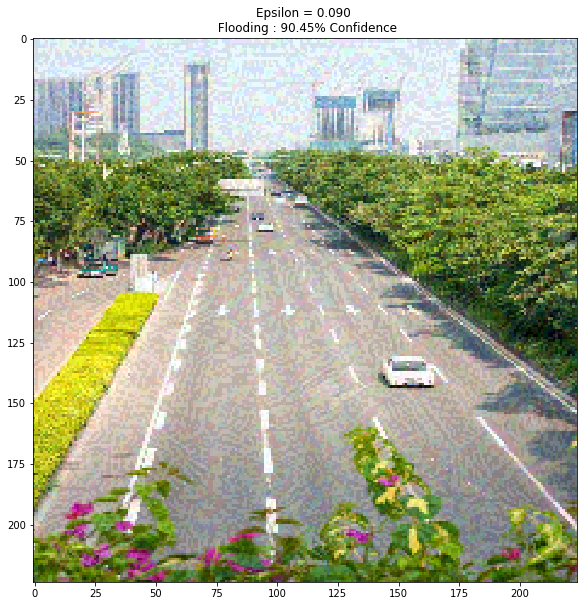

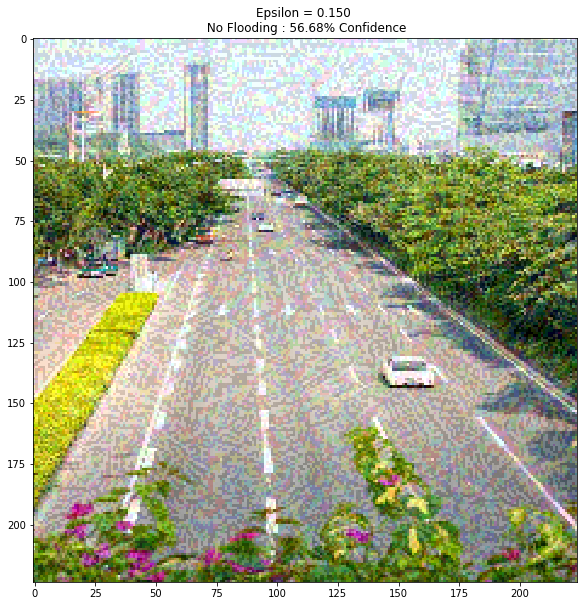

In [9]:
# Test the outcomes using different values of epsilon in the FGSM attack

epsilons = [0, 0.01, 0.09, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])